##### 迁移大型网络

In [1]:
# 加载程序所需要的包
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os


## 一、加载数据

在这里我们将学会如何运用PyTorch的dataset来加载硬盘上的大量图像
只要我们将大量的图像文件都放入指定的文件夹下（训练数据集在data/train下面，校验数据集在data/val下面）
并且将不同的类别分别放到不同的文件夹下。例如在这个例子中，我们有两个类别：bees和ants，我就需要在硬盘上
建立两个文件夹：bees和ants。

我们只需将相应的训练数据和校验数据图像放到这两个文件夹下就可以用datasets的ImageFolder方法自动加载

In [15]:
# 从硬盘文件夹中加载图像数据集

# 数据存储总路径
data_dir = 'D:\project\DLTB\chapter6_transfer\data'
# 图像的大小为224*224
image_size = 224
# 从data_dir/train加载文件
# 加载的过程将会对图像自动作如下的图像增强操作：
# 1. 随机从原始图像中切下来一块224*224大小的区域
# 2. 随机水平翻转图像
# 3. 将图像的色彩数值标准化
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                     transforms.Compose([
                                         transforms.RandomResizedCrop(
                                             image_size),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [
                                             0.229, 0.224, 0.225])
                                     ])
                                     )

# 加载校验数据集，对每个加载的数据进行如下处理：
# 1. 放大到256*256像素
# 2. 从中心区域切割下224*224大小的图像区域
# 3. 将图像的色彩数值标准化
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                   transforms.Compose([
                                       transforms.Resize(256),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [
                                           0.229, 0.224, 0.225])
                                   ])
                                   )

# 创建相应的数据加载器, cpu加载核心数为4
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=True, num_workers=4)

# 读取得出数据中的分类类别数
num_classes = len(train_dataset.classes)

# 检测本机器是否安装GPU，将检测结果记录在布尔变量use_cuda中
use_cuda = torch.cuda.is_available()

# 当可用GPU的时候，将新建立的张量自动加载到GPU中
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor


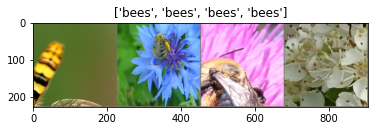

In [3]:
def imshow(inp, title=None):
    # 将一张图打印显示出来，inp为一个张量，title为显示在图像上的文字

    # 一般的张量格式为：channels*image_width*image_height
    # 而一般的图像为image_width*image_height*channels所以，需要将channels转换到最后一个维度
    inp = inp.numpy().transpose((1, 2, 0))

    # 由于在读入图像的时候所有图像的色彩都标准化了，因此我们需要先调回去
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # 将图像绘制出来
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 暂停一会是为了能够将图像显示出来。


# 获取第一个图像batch和标签
images, labels = next(iter(train_loader))

# 将这个batch中的图像制成表格绘制出来
out = torchvision.utils.make_grid(images)

imshow(out, title=[train_dataset.classes[x] for x in labels])


## 二、加载一个卷积神经网络作为对比

In [4]:
# 用于手写数字识别的卷积神经网络
depth = [4, 8]


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 输入通道为3，输出通道为4，窗口大小为5，padding为2
        self.conv1 = nn.Conv2d(3, 4, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)  # 一个窗口为2*2的pooling运算
        # 第二层卷积，输入通道为depth[0], 输出通道为depth[1]，窗口为15，padding为2
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding=2)
        # 一个线性连接层，输入尺寸为最后一层立方体的平铺，输出层512个节点
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1], 512)
        self.fc2 = nn.Linear(512, num_classes)  # 最后一层线性分类单元，输入为

    def forward(self, x):
        # 神经网络完成一步前馈运算的过程，从输入到输出
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x))  # 全链接，激活函数
        x = F.dropout(x, training=self.training)  # 以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x)  # 全链接，激活函数
        x = F.log_softmax(x, dim=1)  # log_softmax可以理解为概率对数值
        return x

    def retrieve_features(self, x):
        # 提取卷积神经网络的特征图的函数，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)


def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行10列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[
        1]  # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    # 将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    rights = pred.eq(labels.data.view_as(pred)).sum()
    # rights装到cpu中，以便后面打印出来   --hq20200726
    rights = rights.cpu() if rights.is_cuda else rights
    return rights, len(labels)  # 返回正确的数量和这一次一共比较了多少元素


In [5]:
# 加载网络
net = ConvNet()
# 如果有GPU就把网络加载到GPU中
net = net.cuda() if use_cuda else net
criterion = nn.CrossEntropyLoss()  # Loss函数的定义
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

record = []  # 记录准确率等数值的容器

# 开始训练循环
num_epochs = 20
net.train(True)  # 给网络模型做标记，标志说模型在训练集上训练
best_model = net
best_r = 0.0
for epoch in range(num_epochs):
    #optimizer = exp_lr_scheduler(optimizer, epoch)
    train_rights = []  # 记录训练数据集准确率的容器
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):  # 针对容器中的每一个批进行循环
        data, target = data.clone().detach().requires_grad_(
            True), target.clone().detach()  # data为图像，target为标签
        # 如果有GPU就把数据加载到GPU上
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data)  # 完成一次预测
        loss = criterion(output, target)  # 计算误差
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 一步随机梯度下降
        right = rightness(output, target)  # 计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        train_rights.append(right)  # 将计算结果装到列表容器中
        # 因为所有计算都在GPU中，打印的数据再加载到CPU中
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())

     # train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]),
               sum([tup[1] for tup in train_rights]))
    # 在测试集上分批运行，并计算总的正确率
    net.eval()  # 标志模型当前为运行阶段
    test_loss = 0
    correct = 0
    vals = []
    # 对测试数据集进行循环
    for data, target in val_loader:
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
        # 如果GPU可用，就把数据加载到GPU中
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data)  # 将特征数据喂入网络，得到分类的输出
        val = rightness(output, target)  # 获得正确样本数以及总样本数
        vals.append(val)  # 记录结果

    # 计算准确率
    val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0]/val_r[1]

    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    # 打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].numpy() / train_r[1], 100. * val_r[0].numpy()/val_r[1]))
    record.append([np.mean(train_losses), train_r[0].numpy() /
                  train_r[1], val_r[0].numpy()/val_r[1]])


训练周期: 0 	Loss: 0.696057	训练正确率: 51.23%, 校验正确率: 52.94%
训练周期: 1 	Loss: 0.691395	训练正确率: 52.87%, 校验正确率: 48.37%
训练周期: 2 	Loss: 0.686359	训练正确率: 52.05%, 校验正确率: 58.17%
训练周期: 3 	Loss: 0.686648	训练正确率: 51.64%, 校验正确率: 64.71%
训练周期: 4 	Loss: 0.677474	训练正确率: 53.69%, 校验正确率: 50.33%
训练周期: 5 	Loss: 0.677203	训练正确率: 52.87%, 校验正确率: 51.63%
训练周期: 6 	Loss: 0.666809	训练正确率: 56.15%, 校验正确率: 60.78%
训练周期: 7 	Loss: 0.658152	训练正确率: 61.48%, 校验正确率: 56.86%
训练周期: 8 	Loss: 0.675357	训练正确率: 53.28%, 校验正确率: 58.17%
训练周期: 9 	Loss: 0.658575	训练正确率: 57.38%, 校验正确率: 61.44%
训练周期: 10 	Loss: 0.644736	训练正确率: 63.93%, 校验正确率: 60.13%
训练周期: 11 	Loss: 0.637699	训练正确率: 61.07%, 校验正确率: 58.17%
训练周期: 12 	Loss: 0.643685	训练正确率: 61.48%, 校验正确率: 60.13%
训练周期: 13 	Loss: 0.655430	训练正确率: 61.89%, 校验正确率: 58.17%
训练周期: 14 	Loss: 0.640924	训练正确率: 63.52%, 校验正确率: 58.82%
训练周期: 15 	Loss: 0.651826	训练正确率: 58.61%, 校验正确率: 59.48%
训练周期: 16 	Loss: 0.627305	训练正确率: 64.75%, 校验正确率: 60.13%
训练周期: 17 	Loss: 0.628996	训练正确率: 62.70%, 校验正确率: 61.44%
训练周期: 18 	Loss: 0.637100	训练正确率: 61.07%

In [6]:
# 在测试集上分批运行，并计算总的正确率
net.eval()  # 标志模型当前为运行阶段
test_loss = 0
correct = 0
vals = []

# 对测试数据集进行循环
for data, target in val_loader:
    data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    output = net(data)  # 将特征数据喂入网络，得到分类的输出
    val = rightness(output, target)  # 获得正确样本数以及总样本数
    vals.append(val)  # 记录结果

# 计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].numpy() / rights[1]
right_rate


0.6143790849673203

Text(0, 0.5, 'Error Rate')

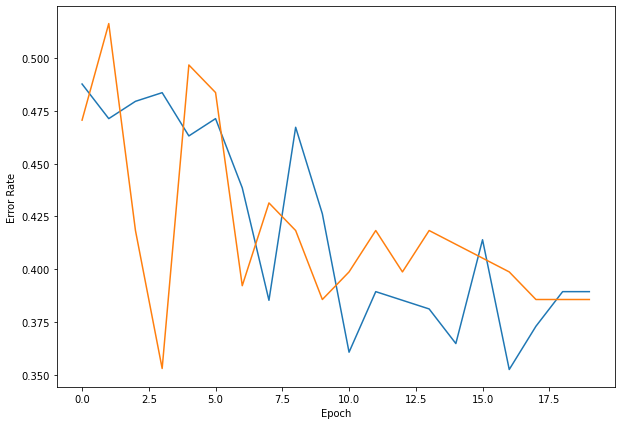

In [7]:
# 绘制误差率曲线
x = [x[0] for x in record]
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]
# plt.plot(x)
plt.figure(figsize=(10, 7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')


## 三、加载已训练好的Residual Network进行迁移学习预训练

In [8]:
# 加载模型库中的residual network，并设置pretrained为true，这样便可加载相应的权重
net = models.resnet101(pretrained=True)
# 如果存在GPU，就将网络加载到GPU上
net = net.cuda() if use_cuda else net
# 将网络的架构打印出来
net


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\ncrc190/.cache\torch\hub\checkpoints\resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:22<00:00, 7.90MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# 读取最后线性层的输入单元数，这是前面各层卷积提取到的特征数量
num_ftrs = net.fc.in_features

# 重新定义一个全新的线性层，它的输出为2，原本是1000
net.fc = nn.Linear(num_ftrs, 2)

# 如果存在GPU则将网络加载到GPU中
net.fc = net.fc.cuda() if use_cuda else net.fc

criterion = nn.CrossEntropyLoss()  # Loss函数的定义
# 将网络的所有参数放入优化器中
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

record = []  # 记录准确率等数值的容器

# 开始训练循环
num_epochs = 20
net.train(True)  # 给网络模型做标记，标志说模型在训练集上训练
best_model = net
best_r = 0.0
for epoch in range(num_epochs):
    #optimizer = exp_lr_scheduler(optimizer, epoch)
    train_rights = []  # 记录训练数据集准确率的容器
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):  # 针对容器中的每一个批进行循环
        data, target = data.clone().detach().requires_grad_(
            True), target.clone().detach()  # data为图像，target为标签
        # 如果存在GPU则将变量加载到GPU中
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data)  # 完成一次预测
        loss = criterion(output, target)  # 计算误差
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 一步随机梯度下降
        right = rightness(output, target)  # 计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        train_rights.append(right)  # 将计算结果装到列表容器中
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())

     # train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]),
               sum([tup[1] for tup in train_rights]))

    # 在测试集上分批运行，并计算总的正确率
    net.eval()  # 标志模型当前为运行阶段
    test_loss = 0
    correct = 0
    vals = []
    # 对测试数据集进行循环
    for data, target in val_loader:
        # 如果存在GPU则将变量加载到GPU中
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
        output = net(data)  # 将特征数据喂入网络，得到分类的输出
        val = rightness(output, target)  # 获得正确样本数以及总样本数
        vals.append(val)  # 记录结果

    # 计算准确率
    val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0].numpy()/val_r[1]

    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    # 打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].numpy() / train_r[1], 100. * val_r[0].numpy()/val_r[1]))
    record.append([np.mean(train_losses), train_r[0].numpy() /
                  train_r[1], val_r[0].numpy()/val_r[1]])


训练周期: 0 	Loss: 0.640620	训练正确率: 61.89%, 校验正确率: 90.85%
训练周期: 1 	Loss: 0.373657	训练正确率: 88.52%, 校验正确率: 94.77%
训练周期: 2 	Loss: 0.180267	训练正确率: 94.26%, 校验正确率: 93.46%
训练周期: 3 	Loss: 0.167677	训练正确率: 93.03%, 校验正确率: 94.77%
训练周期: 4 	Loss: 0.068254	训练正确率: 97.95%, 校验正确率: 93.46%
训练周期: 5 	Loss: 0.129224	训练正确率: 94.26%, 校验正确率: 94.12%
训练周期: 6 	Loss: 0.128777	训练正确率: 95.90%, 校验正确率: 90.85%
训练周期: 7 	Loss: 0.084046	训练正确率: 95.90%, 校验正确率: 93.46%
训练周期: 8 	Loss: 0.105851	训练正确率: 95.90%, 校验正确率: 92.81%
训练周期: 9 	Loss: 0.062389	训练正确率: 97.95%, 校验正确率: 94.77%
训练周期: 10 	Loss: 0.072582	训练正确率: 97.13%, 校验正确率: 93.46%
训练周期: 11 	Loss: 0.028058	训练正确率: 98.77%, 校验正确率: 92.81%
训练周期: 12 	Loss: 0.099655	训练正确率: 97.54%, 校验正确率: 94.77%
训练周期: 13 	Loss: 0.083060	训练正确率: 97.54%, 校验正确率: 93.46%
训练周期: 14 	Loss: 0.064245	训练正确率: 97.13%, 校验正确率: 94.12%
训练周期: 15 	Loss: 0.038119	训练正确率: 99.59%, 校验正确率: 94.77%
训练周期: 16 	Loss: 0.071211	训练正确率: 97.13%, 校验正确率: 94.77%
训练周期: 17 	Loss: 0.044521	训练正确率: 97.95%, 校验正确率: 92.81%
训练周期: 18 	Loss: 0.033409	训练正确率: 98.77%

Text(0, 0.5, 'Error Rate')

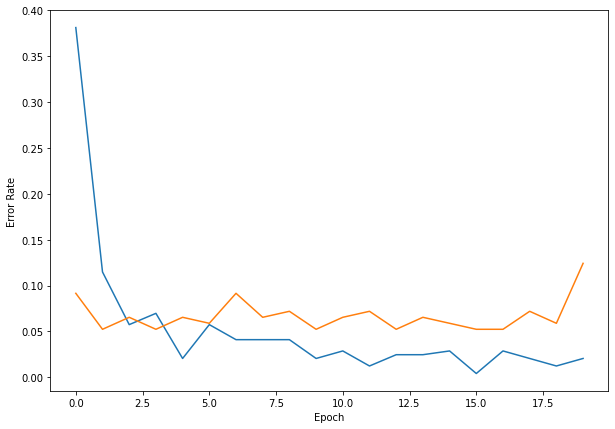

In [10]:
# 打印误差率曲线
x = [x[0] for x in record]
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]
# plt.plot(x)
plt.figure(figsize=(10, 7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')


In [16]:
# 将预训练的模型用于测试数据，打印其分类效果
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    for i, data in enumerate(val_loader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')

            ax.set_title('predicted: {}'.format(val_dataset.classes[preds[j]]))
            imshow(data[0][j])

            if images_so_far == num_images:
                return


visualize_model(net)

plt.ioff()
plt.show()


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 1.69 GiB already allocated; 0 bytes free; 1.73 GiB reserved in total by PyTorch)

<Figure size 1080x720 with 0 Axes>

## 四、迁移Residual网络并固定权值

In [1]:
# 加载residual网络模型
net = torchvision.models.resnet18(pretrained=True)
# 将模型放入GPU中
net = net.cuda() if use_cuda else net

# 循环网络，将所有参数设为不更新梯度信息
for param in net.parameters():
    param.requires_grad = False

# 将网络最后一层现行层换掉
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
net.fc = net.fc.cuda() if use_cuda else net.fc

criterion = nn.CrossEntropyLoss()  # Loss函数的定义
# 仅将线性层的参数放入优化器中
optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)

record = []  # 记录准确率等数值的容器

# 开始训练循环
num_epochs = 20
net.train(True)  # 给网络模型做标记，标志说模型在训练集上训练
best_model = net
best_r = 0.0
for epoch in range(num_epochs):
    #optimizer = exp_lr_scheduler(optimizer, epoch)
    train_rights = []  # 记录训练数据集准确率的容器
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):  # 针对容器中的每一个批进行循环
        data, target = data.clone().detach().requires_grad_(True), target.clone().detach()  # data为图像，target为标签
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data)  # 完成一次预测
        loss = criterion(output, target)  # 计算误差
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 一步随机梯度下降
        right = rightness(output, target)  # 计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        train_rights.append(right)  # 将计算结果装到列表容器中
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())

     # train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]),
               sum([tup[1] for tup in train_rights]))

    # 在测试集上分批运行，并计算总的正确率
    net.eval()  # 标志模型当前为运行阶段
    test_loss = 0
    correct = 0
    vals = []
    # 对测试数据集进行循环
    for data, target in val_loader:
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data)  # 将特征数据喂入网络，得到分类的输出
        val = rightness(output, target)  # 获得正确样本数以及总样本数
        vals.append(val)  # 记录结果

    # 计算准确率
    val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0].numpy()/val_r[1]

    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    # 打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].numpy() / train_r[1], 100. * val_r[0].numpy()/val_r[1]))
    record.append([np.mean(train_losses), train_r[0].numpy() /
                  train_r[1], val_r[0].numpy()/val_r[1]])


NameError: name 'torchvision' is not defined

Text(0, 0.5, 'Error Rate')

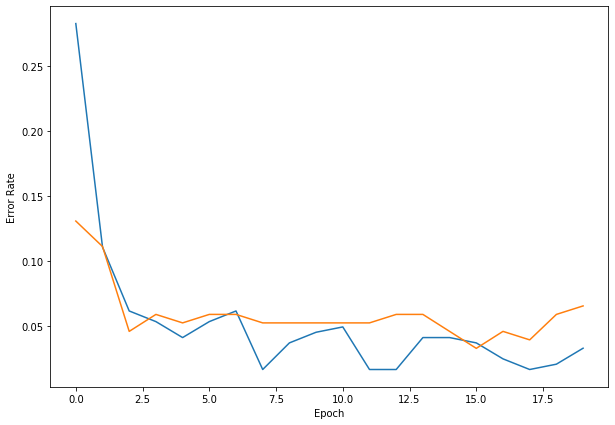

In [36]:
# 打印误差曲线
x = [x[0] for x in record]
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]
# plt.plot(x)
plt.figure(figsize=(10, 7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')


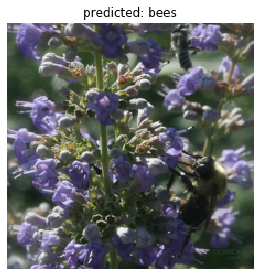

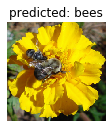

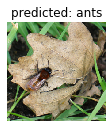

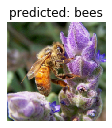

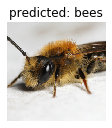

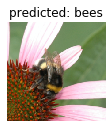

In [37]:
# 展示分类结果
visualize_model(best_model)

plt.ioff()
plt.show()


## 五、系统化试验

为了比较不同迁移学习方法对于识别准确度的影响，我们系统化地做了实验，每一种迁移方法都做了10次实验并做平均

In [38]:
times = 10  # 每组实验10次
results = {}  # 实验结果都装入results中
models_name = ['conv', 'transfer_pretrain', 'transfer_fixed']  # 三组不同的实验名称
for model in models_name:
    # 根据不同的实验名称加载网络
    if model == 'conv':
        net = ConvNet()
        net = net.cuda() if use_cuda else net
        criterion = nn.CrossEntropyLoss()  # Loss函数的定义
        optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    if model == 'transfer_pretrain':
        net = models.resnet18(pretrained=True)
        net = net.cuda() if use_cuda else net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, 2)
        net.fc = net.fc.cuda() if use_cuda else net.fc

        criterion = nn.CrossEntropyLoss()  # Loss函数的定义
        optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    if model == 'transfer_fixed':
        net = models.resnet18(pretrained=True)
        net = net.cuda() if use_cuda else net
        for param in net.parameters():
            param.requires_grad = False
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, 2)
        net.fc = net.fc.cuda() if use_cuda else net.fc

        criterion = nn.CrossEntropyLoss()  # Loss函数的定义
        optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)
    # 循环多次
    for time in range(times):
        print(model, time)
        record = []  # 记录准确率等数值的容器
        # 开始训练循环
        num_epochs = 20
        net.train(True)  # 给网络模型做标记，标志说模型在训练集上训练
        for epoch in range(num_epochs):
            train_rights = []  # 记录训练数据集准确率的容器
            train_losses = []
            for batch_idx, (data, target) in enumerate(train_loader):  # 针对容器中的每一个批进行循环
                data, target = data.clone().detach().requires_grad_(True), target.clone().detach()  # 将data为图像，target为标签
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                output = net(data)  # 完成一次预测
                loss = criterion(output, target)  # 计算误差
                optimizer.zero_grad()  # 清空梯度
                loss.backward()  # 反向传播
                optimizer.step()  # 一步随机梯度下降
                # 计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                right = rightness(output, target)
                train_rights.append(right)  # 将计算结果装到列表容器中
             # train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
            train_r = (sum([tup[0] for tup in train_rights]),
                       sum([tup[1] for tup in train_rights]))

            # 在测试集上分批运行，并计算总的正确率
            net.eval()  # 标志模型当前为运行阶段
            test_loss = 0
            correct = 0
            vals = []
            # 对测试数据集进行循环
            for data, target in val_loader:
                data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                output = net(data)  # 将特征数据喂入网络，得到分类的输出
                val = rightness(output, target)  # 获得正确样本数以及总样本数
                vals.append(val)  # 记录结果

            # 计算准确率
            val_r = (sum([tup[0] for tup in vals]),
                     sum([tup[1] for tup in vals]))
            val_ratio = 1.0*val_r[0].numpy()/val_r[1]

            if val_ratio > best_r:
                best_r = val_ratio
                best_model = copy.deepcopy(net)
            # 打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print('训练周期: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(epoch, 100. * train_r[0].numpy() / train_r[1], 100. * val_r[0].numpy()/val_r[1]))
            record.append([train_r[0].numpy() / train_r[1],val_r[0].numpy()/val_r[1]])
        # 将结果加入results中，record记载了每一个打印周期的训练准确度和校验准确度
        results[(model, time)] = record


conv 0
训练周期: 0.000000	训练正确率: 43.85%, 校验正确率: 56.86%
训练周期: 1.000000	训练正确率: 53.28%, 校验正确率: 53.59%
训练周期: 2.000000	训练正确率: 56.15%, 校验正确率: 58.17%
训练周期: 3.000000	训练正确率: 56.97%, 校验正确率: 55.56%
训练周期: 4.000000	训练正确率: 56.15%, 校验正确率: 52.94%
训练周期: 5.000000	训练正确率: 55.33%, 校验正确率: 52.94%
训练周期: 6.000000	训练正确率: 59.02%, 校验正确率: 53.59%
训练周期: 7.000000	训练正确率: 56.97%, 校验正确率: 55.56%
训练周期: 8.000000	训练正确率: 59.02%, 校验正确率: 56.86%
训练周期: 9.000000	训练正确率: 59.84%, 校验正确率: 58.82%
训练周期: 10.000000	训练正确率: 59.84%, 校验正确率: 56.86%
训练周期: 11.000000	训练正确率: 58.20%, 校验正确率: 58.82%
训练周期: 12.000000	训练正确率: 63.11%, 校验正确率: 60.13%
训练周期: 13.000000	训练正确率: 64.75%, 校验正确率: 62.09%
训练周期: 14.000000	训练正确率: 64.75%, 校验正确率: 60.13%
训练周期: 15.000000	训练正确率: 61.07%, 校验正确率: 56.21%
训练周期: 16.000000	训练正确率: 63.52%, 校验正确率: 59.48%
训练周期: 17.000000	训练正确率: 59.43%, 校验正确率: 58.17%
训练周期: 18.000000	训练正确率: 63.93%, 校验正确率: 61.44%
训练周期: 19.000000	训练正确率: 61.89%, 校验正确率: 64.05%
conv 1
训练周期: 0.000000	训练正确率: 63.11%, 校验正确率: 62.75%
训练周期: 1.000000	训练正确率: 64.75%, 校验正确率: 62.09%
训练周期: 2.

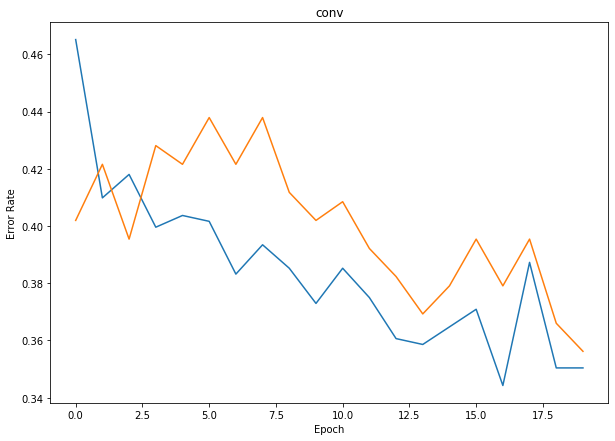

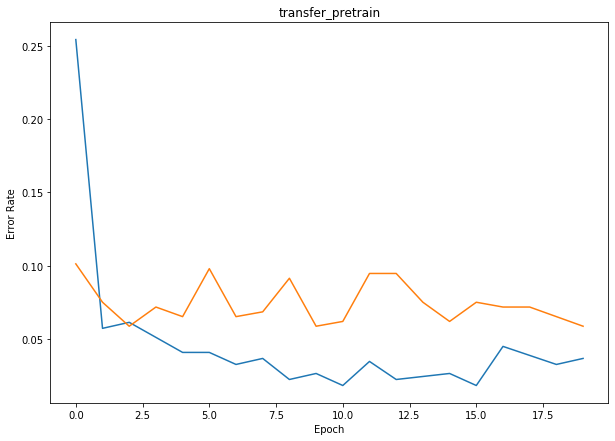

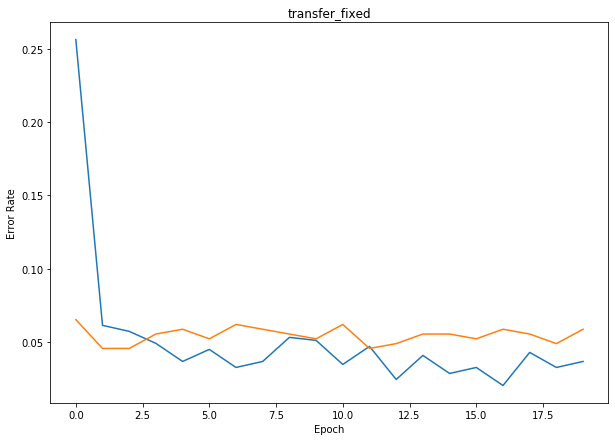

In [39]:
# 将错误率对不同次实验取平均值，并放入errors中，并将不同实验的错误率曲线结果打印出来本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第IV课的配套源代码
for model in models_name:
    errors = []
    for time in range(times):
        rs = results[(model, time)]
        errors.append(rs)
    aa = np.array(errors)
    avg = np.mean(aa, 0)
    plt.figure(figsize=(10, 7))
    plt.title(model)
    plt.plot([1 - i for i in avg])
    plt.xlabel('Epoch')
    plt.ylabel('Error Rate')
